# 04. Performance Analysis & Optimization

Notebook để đo lường thời gian chạy từng step và tối ưu hóa performance.

In [1]:
import sys
sys.path.insert(0, '..')

import pandas as pd
import numpy as np
import time
from functools import wraps
from IPython.display import display
import matplotlib.pyplot as plt

In [2]:
from config import (CFG, SEGMENT_COLS, BUCKETS_CANON, BUCKETS_30P, BUCKETS_60P, BUCKETS_90P,
                    ABSORBING_BASE, MAX_MOB, DENOM_LEVEL)
from data_io import load_parquet, validate_schema
from transitions import prepare_transitions, estimate_transition_matrices
from forecast import build_initial_vectors, forecast, merge_forecast_to_snapshot
from metrics import compute_all_del_metrics
from calibration import fit_del_curve_factors, apply_matrix_calibration
from export import export_all_del_to_excel

## Performance Measurement Utilities

In [3]:
# Performance measurement utilities
performance_log = []

def time_step(step_name):
    """Decorator to measure execution time of functions"""
    def decorator(func):
        @wraps(func)
        def wrapper(*args, **kwargs):
            start_time = time.time()
            result = func(*args, **kwargs)
            end_time = time.time()
            duration = end_time - start_time
            
            performance_log.append({
                'step': step_name,
                'duration': duration,
                'timestamp': time.strftime('%H:%M:%S', time.localtime(start_time))
            })
            
            print(f"⏱️  {step_name}: {duration:.2f}s")
            return result
        return wrapper
    return decorator

def measure_step(step_name, func, *args, **kwargs):
    """Measure execution time of a function call"""
    start_time = time.time()
    result = func(*args, **kwargs)
    end_time = time.time()
    duration = end_time - start_time
    
    performance_log.append({
        'step': step_name,
        'duration': duration,
        'timestamp': time.strftime('%H:%M:%S', time.localtime(start_time))
    })
    
    print(f"⏱️  {step_name}: {duration:.2f}s")
    return result

def print_performance_summary():
    """Print performance summary"""
    if not performance_log:
        print("No performance data available")
        return
    
    df_perf = pd.DataFrame(performance_log)
    total_time = df_perf['duration'].sum()
    
    print("\n" + "="*60)
    print("PERFORMANCE SUMMARY")
    print("="*60)
    
    df_perf['percentage'] = (df_perf['duration'] / total_time * 100).round(1)
    df_perf['duration_formatted'] = df_perf['duration'].apply(lambda x: f"{x:.2f}s")
    
    display(df_perf[['step', 'duration_formatted', 'percentage', 'timestamp']])
    
    print(f"\n🕐 Total execution time: {total_time:.2f}s ({total_time/60:.1f} minutes)")
    
    # Find bottlenecks
    bottlenecks = df_perf[df_perf['percentage'] > 10].sort_values('duration', ascending=False)
    if len(bottlenecks) > 0:
        print("\n🐌 Performance bottlenecks (>10% of total time):")
        for _, row in bottlenecks.iterrows():
            print(f"  • {row['step']}: {row['duration_formatted']} ({row['percentage']}%)")
    
    return df_perf

# Clear previous logs
performance_log.clear()
print("Performance measurement utilities loaded.")

Performance measurement utilities loaded.


## Step 1: Data Loading & Preparation

In [4]:
# Step 1: Load data
df = measure_step("1. Load parquet data", load_parquet, '../Oct25.parquet')
print(f"Data shape: {df.shape}")

# Step 2: Validate schema
measure_step("2. Validate schema", validate_schema, df, CFG, SEGMENT_COLS, BUCKETS_CANON)

# Step 3: Prepare transitions
df_trans = measure_step("3. Prepare transitions", prepare_transitions, 
                       df, CFG, SEGMENT_COLS, BUCKETS_CANON, ABSORBING_BASE)
print(f"Transitions shape: {df_trans.shape}")

Loading parquet file: ..\Oct25.parquet
⏱️  1. Load parquet data: 10.39s
Data shape: (27514143, 14)
⏱️  2. Validate schema: 2.94s
⏱️  3. Prepare transitions: 81.28s
Transitions shape: (25628053, 7)


## Step 2: Transition Matrix Estimation

In [5]:
# Step 4: Estimate transition matrices (usually the slowest step)
segment_levels = [("GLOBAL", []), ("COARSE", [SEGMENT_COLS[0]] if SEGMENT_COLS else []), ("FULL", SEGMENT_COLS)]
prior_strengths = {"coarse": 100.0, "full": 50.0}

transitions_dict, transitions_long_df, meta_df = measure_step(
    "4. Estimate transition matrices",
    estimate_transition_matrices,
    df_trans, CFG, BUCKETS_CANON, segment_levels, MAX_MOB, "ead", 30, prior_strengths, None
)

print(f"Generated {len(transitions_dict)} matrices")
print(f"Transitions long: {transitions_long_df.shape}")
print(f"Meta data: {meta_df.shape}")

⏱️  4. Estimate transition matrices: 87.00s
Generated 298 matrices
Transitions long: (14602, 6)
Meta data: (298, 5)


## Step 3: Forecasting

In [6]:
# Step 5: Build initial vectors
df_init, denom_map = measure_step(
    "5. Build initial vectors",
    build_initial_vectors,
    df, CFG, BUCKETS_CANON, SEGMENT_COLS, DENOM_LEVEL
)
print(f"Initial vectors: {df_init.shape}")

# Step 6: Forecast
forecast_df = measure_step(
    "6. Forecast EAD distribution",
    forecast,
    df_init, transitions_dict, BUCKETS_CANON, MAX_MOB
)
print(f"Forecast: {forecast_df.shape}")

⏱️  5. Build initial vectors: 34.60s
Initial vectors: (332, 4)
⏱️  6. Forecast EAD distribution: 1.47s
Forecast: (32725, 5)


## Step 4: DEL Metrics Computation

In [7]:
# Step 7: Compute DEL metrics
del_results = measure_step(
    "7. Compute all DEL metrics",
    compute_all_del_metrics,
    df, forecast_df, CFG, SEGMENT_COLS, MAX_MOB, DENOM_LEVEL,
    BUCKETS_30P, BUCKETS_60P, BUCKETS_90P
)

for k, v in del_results.items():
    print(f"  {k}: {v[0].shape}")

⏱️  7. Compute all DEL metrics: 575.64s
  DEL30: (187, 27)
  DEL60: (187, 27)
  DEL90: (187, 27)


## Step 5: Loan-Level Mapping

In [8]:
# Step 8: Map forecast to loan level
df_with_forecast = measure_step(
    "8. Map forecast to loan level",
    merge_forecast_to_snapshot,
    df, forecast_df, CFG, SEGMENT_COLS, BUCKETS_CANON,
    bad_states_30p=BUCKETS_30P,
    bad_states_60p=BUCKETS_60P,
    bad_states_90p=BUCKETS_90P
)
print(f"Loan-level forecast: {df_with_forecast.shape}")

c:\Users\User\Projection_kiro\notebooks\..\forecast.py:350: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  fct_agg = forecast_df.groupby(["cohort", "segment_key", "mob"]).apply(


⏱️  8. Map forecast to loan level: 240.36s
Loan-level forecast: (27514143, 26)


## Step 6: Export

In [9]:
# Step 9: Export to Excel
import os
os.makedirs('../out', exist_ok=True)

measure_step(
    "9. Export to Excel",
    export_all_del_to_excel,
    '../out/performance_test.xlsx', transitions_long_df, del_results,
    forecast_df=forecast_df, meta_df=meta_df
)

# Step 10: Export parquet
measure_step(
    "10. Export loan-level parquet",
    lambda: df_with_forecast.to_parquet('../out/performance_test_loans.parquet', index=False)
)

print("All exports completed.")

⏱️  9. Export to Excel: 29.88s
⏱️  10. Export loan-level parquet: 55.55s
All exports completed.


## Performance Analysis

In [10]:
# Print performance summary
df_perf = print_performance_summary()


PERFORMANCE SUMMARY


,step,duration_formatted,percentage,timestamp
0,1. Load parquet data,10.39s,0.9,15:06:44
1,2. Validate schema,2.94s,0.3,15:06:55
2,3. Prepare transitions,81.28s,7.3,15:06:58
3,4. Estimate transition matrices,87.00s,7.8,15:08:19
4,5. Build initial vectors,34.60s,3.1,15:09:46
5,6. Forecast EAD distribution,1.47s,0.1,15:10:21
6,7. Compute all DEL metrics,575.64s,51.4,15:10:22
7,8. Map forecast to loan level,240.36s,21.5,15:19:58
8,9. Export to Excel,29.88s,2.7,15:23:58
9,10. Export loan-level parquet,55.55s,5.0,15:24:28



🕐 Total execution time: 1119.12s (18.7 minutes)

🐌 Performance bottlenecks (>10% of total time):
  • 7. Compute all DEL metrics: 575.64s (51.4%)
  • 8. Map forecast to loan level: 240.36s (21.5%)


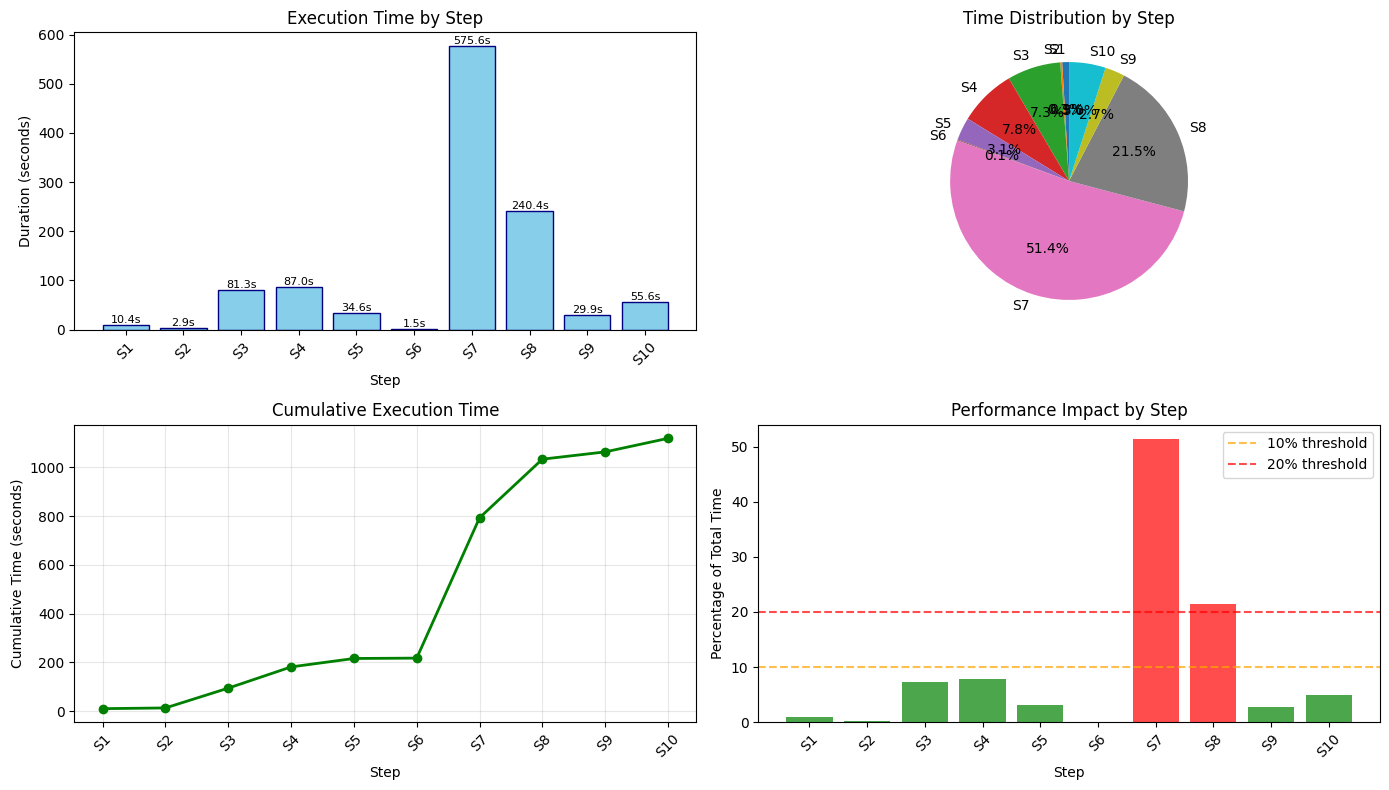


Step Details:
S1: 1. Load parquet data
S2: 2. Validate schema
S3: 3. Prepare transitions
S4: 4. Estimate transition matrices
S5: 5. Build initial vectors
S6: 6. Forecast EAD distribution
S7: 7. Compute all DEL metrics
S8: 8. Map forecast to loan level
S9: 9. Export to Excel
S10: 10. Export loan-level parquet


In [11]:
# Visualize performance
plt.figure(figsize=(14, 8))

# Bar chart of execution times
plt.subplot(2, 2, 1)
bars = plt.bar(range(len(df_perf)), df_perf['duration'], color='skyblue', edgecolor='navy')
plt.xlabel('Step')
plt.ylabel('Duration (seconds)')
plt.title('Execution Time by Step')
plt.xticks(range(len(df_perf)), [f"S{i+1}" for i in range(len(df_perf))], rotation=45)

# Add value labels on bars
for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.1,
             f'{height:.1f}s', ha='center', va='bottom', fontsize=8)

# Pie chart of time distribution
plt.subplot(2, 2, 2)
plt.pie(df_perf['duration'], labels=[f"S{i+1}" for i in range(len(df_perf))], 
        autopct='%1.1f%%', startangle=90)
plt.title('Time Distribution by Step')

# Cumulative time
plt.subplot(2, 2, 3)
cumulative = df_perf['duration'].cumsum()
plt.plot(range(len(df_perf)), cumulative, 'o-', color='green', linewidth=2, markersize=6)
plt.xlabel('Step')
plt.ylabel('Cumulative Time (seconds)')
plt.title('Cumulative Execution Time')
plt.xticks(range(len(df_perf)), [f"S{i+1}" for i in range(len(df_perf))], rotation=45)
plt.grid(True, alpha=0.3)

# Performance breakdown
plt.subplot(2, 2, 4)
colors = ['red' if x > 20 else 'orange' if x > 10 else 'green' for x in df_perf['percentage']]
bars = plt.bar(range(len(df_perf)), df_perf['percentage'], color=colors, alpha=0.7)
plt.xlabel('Step')
plt.ylabel('Percentage of Total Time')
plt.title('Performance Impact by Step')
plt.xticks(range(len(df_perf)), [f"S{i+1}" for i in range(len(df_perf))], rotation=45)
plt.axhline(y=10, color='orange', linestyle='--', alpha=0.7, label='10% threshold')
plt.axhline(y=20, color='red', linestyle='--', alpha=0.7, label='20% threshold')
plt.legend()

plt.tight_layout()
plt.show()

# Print step details
print("\nStep Details:")
for i, row in df_perf.iterrows():
    print(f"S{i+1}: {row['step']}")

## Optimization Recommendations

In [12]:
# Analyze bottlenecks and provide optimization recommendations
print("\n" + "="*60)
print("OPTIMIZATION RECOMMENDATIONS")
print("="*60)

# Identify major bottlenecks
major_bottlenecks = df_perf[df_perf['percentage'] > 20].sort_values('duration', ascending=False)
minor_bottlenecks = df_perf[(df_perf['percentage'] > 10) & (df_perf['percentage'] <= 20)].sort_values('duration', ascending=False)

if len(major_bottlenecks) > 0:
    print("\n🚨 MAJOR BOTTLENECKS (>20% of total time):")
    for _, row in major_bottlenecks.iterrows():
        step_name = row['step']
        print(f"\n• {step_name} ({row['percentage']}% - {row['duration']:.1f}s)")
        
        # Specific recommendations based on step
        if "transition matrices" in step_name.lower():
            print("  💡 Optimizations:")
            print("     - Use vectorized operations (already implemented)")
            print("     - Consider reducing MAX_MOB if not all needed")
            print("     - Reduce segment hierarchy levels if possible")
            print("     - Use multiprocessing for different segments")
            
        elif "del metrics" in step_name.lower():
            print("  💡 Optimizations:")
            print("     - Compute only needed DEL types (30/60/90)")
            print("     - Use chunked processing for large datasets")
            print("     - Cache intermediate results")
            
        elif "forecast" in step_name.lower():
            print("  💡 Optimizations:")
            print("     - Use sparse matrices for large state spaces")
            print("     - Vectorize matrix multiplications")
            print("     - Parallel processing by cohort-segment")
            
        elif "loan level" in step_name.lower():
            print("  💡 Optimizations:")
            print("     - Use efficient merge operations")
            print("     - Consider sampling for very large datasets")
            print("     - Use categorical data types")
            
        elif "export" in step_name.lower():
            print("  💡 Optimizations:")
            print("     - Use compression for parquet files")
            print("     - Write Excel sheets in parallel")
            print("     - Consider CSV export for faster I/O")

if len(minor_bottlenecks) > 0:
    print("\n⚠️  MINOR BOTTLENECKS (10-20% of total time):")
    for _, row in minor_bottlenecks.iterrows():
        print(f"  • {row['step']}: {row['percentage']}% ({row['duration']:.1f}s)")

# General recommendations
print("\n🔧 GENERAL OPTIMIZATION STRATEGIES:")
print("\n1. Data Size Optimization:")
print("   - Use appropriate data types (int32 vs int64, category vs object)")
print("   - Filter data early in the pipeline")
print("   - Consider data sampling for development/testing")

print("\n2. Memory Management:")
print("   - Use chunked processing for large datasets")
print("   - Clear intermediate variables when not needed")
print("   - Use memory-efficient data structures")

print("\n3. Parallel Processing:")
print("   - Process different segments in parallel")
print("   - Use multiprocessing for independent computations")
print("   - Consider Dask for very large datasets")

print("\n4. Caching:")
print("   - Cache transition matrices if reused")
print("   - Save intermediate results to disk")
print("   - Use memoization for expensive computations")

# Data size analysis
print("\n📊 DATA SIZE ANALYSIS:")
print(f"   - Original data: {df.shape[0]:,} rows × {df.shape[1]} columns")
print(f"   - Transitions: {df_trans.shape[0]:,} rows × {df_trans.shape[1]} columns")
print(f"   - Forecast: {forecast_df.shape[0]:,} rows × {forecast_df.shape[1]} columns")
print(f"   - Loan-level: {df_with_forecast.shape[0]:,} rows × {df_with_forecast.shape[1]} columns")
print(f"   - Transition matrices: {len(transitions_dict):,} matrices")

# Memory usage
memory_usage = {
    'Original data': df.memory_usage(deep=True).sum() / 1024**2,
    'Transitions': df_trans.memory_usage(deep=True).sum() / 1024**2,
    'Forecast': forecast_df.memory_usage(deep=True).sum() / 1024**2,
    'Loan-level': df_with_forecast.memory_usage(deep=True).sum() / 1024**2
}

print("\n💾 MEMORY USAGE:")
for name, usage in memory_usage.items():
    print(f"   - {name}: {usage:.1f} MB")
print(f"   - Total: {sum(memory_usage.values()):.1f} MB")


OPTIMIZATION RECOMMENDATIONS

🚨 MAJOR BOTTLENECKS (>20% of total time):

• 7. Compute all DEL metrics (51.4% - 575.6s)
  💡 Optimizations:
     - Compute only needed DEL types (30/60/90)
     - Use chunked processing for large datasets
     - Cache intermediate results

• 8. Map forecast to loan level (21.5% - 240.4s)
  💡 Optimizations:
     - Use sparse matrices for large state spaces
     - Vectorize matrix multiplications
     - Parallel processing by cohort-segment

🔧 GENERAL OPTIMIZATION STRATEGIES:

1. Data Size Optimization:
   - Use appropriate data types (int32 vs int64, category vs object)
   - Filter data early in the pipeline
   - Consider data sampling for development/testing

2. Memory Management:
   - Use chunked processing for large datasets
   - Clear intermediate variables when not needed
   - Use memory-efficient data structures

3. Parallel Processing:
   - Process different segments in parallel
   - Use multiprocessing for independent computations
   - Consider Das

## Quick Optimization Test

In [13]:
# Test data type optimization
print("\n🧪 QUICK OPTIMIZATION TEST: Data Types")
print("="*50)

# Current data types
print("Current data types:")
for col in df.columns:
    print(f"  {col}: {df[col].dtype}")

# Optimize data types
df_optimized = df.copy()

# Convert to more efficient types
if df_optimized[CFG['mob']].dtype == 'int64':
    df_optimized[CFG['mob']] = df_optimized[CFG['mob']].astype('int8')
    
if df_optimized[CFG['bucket']].dtype == 'object':
    df_optimized[CFG['bucket']] = df_optimized[CFG['bucket']].astype('category')
    
if 'PRODUCT_TYPE' in df_optimized.columns and df_optimized['PRODUCT_TYPE'].dtype == 'object':
    df_optimized['PRODUCT_TYPE'] = df_optimized['PRODUCT_TYPE'].astype('category')

# Compare memory usage
original_memory = df.memory_usage(deep=True).sum() / 1024**2
optimized_memory = df_optimized.memory_usage(deep=True).sum() / 1024**2
memory_savings = (original_memory - optimized_memory) / original_memory * 100

print(f"\nMemory usage comparison:")
print(f"  Original: {original_memory:.1f} MB")
print(f"  Optimized: {optimized_memory:.1f} MB")
print(f"  Savings: {memory_savings:.1f}% ({original_memory - optimized_memory:.1f} MB)")

if memory_savings > 5:
    print("\n✅ Significant memory savings! Consider implementing data type optimization.")
else:
    print("\n📝 Minor memory savings. Data types are already fairly optimized.")


🧪 QUICK OPTIMIZATION TEST: Data Types
Current data types:
  CUTOFF_DATE: datetime64[ns]
  AGREEMENT_ID: int64
  DISBURSAL_DATE: datetime64[ns]
  DISBURSAL_AMOUNT: float64
  DPD_EOM: int64
  RISK_BUCKET: object
  PRINCIPLE_OUTSTANDING: float64
  STATUS: object
  MOB: int64
  PRODUCT_TYPE: object
  NPA_STAGEID: object
  DPD_GROUP: object
  STATE_MODEL: object
  RISK_SCORE: object

Memory usage comparison:
  Original: 11992.1 MB
  Optimized: 8614.4 MB
  Savings: 28.2% (3377.6 MB)

✅ Significant memory savings! Consider implementing data type optimization.


## Performance Summary & Action Items

In [14]:
# Final summary and action items
total_time = df_perf['duration'].sum()
slowest_step = df_perf.loc[df_perf['duration'].idxmax()]

print("\n" + "="*60)
print("PERFORMANCE SUMMARY & ACTION ITEMS")
print("="*60)

print(f"\n📈 Overall Performance:")
print(f"   • Total execution time: {total_time:.1f}s ({total_time/60:.1f} minutes)")
print(f"   • Slowest step: {slowest_step['step']} ({slowest_step['duration']:.1f}s)")
print(f"   • Data processed: {df.shape[0]:,} loans, {len(transitions_dict):,} matrices")

# Performance rating
if total_time < 30:
    rating = "🚀 EXCELLENT"
elif total_time < 60:
    rating = "✅ GOOD"
elif total_time < 120:
    rating = "⚠️  ACCEPTABLE"
else:
    rating = "🐌 NEEDS OPTIMIZATION"

print(f"   • Performance rating: {rating}")

print(f"\n🎯 Priority Action Items:")
action_items = []

# Generate action items based on bottlenecks
for _, row in df_perf.iterrows():
    if row['percentage'] > 25:
        action_items.append(f"HIGH: Optimize '{row['step']}' ({row['percentage']:.1f}% of total time)")
    elif row['percentage'] > 15:
        action_items.append(f"MEDIUM: Review '{row['step']}' ({row['percentage']:.1f}% of total time)")

if not action_items:
    action_items.append("LOW: Performance is well-balanced, consider general optimizations")

for i, item in enumerate(action_items, 1):
    print(f"   {i}. {item}")

print(f"\n💡 Quick Wins:")
print(f"   • Use data type optimization (potential {memory_savings:.1f}% memory savings)")
print(f"   • Cache transition matrices if running multiple scenarios")
print(f"   • Consider reducing MAX_MOB if full range not needed")
print(f"   • Use parquet instead of Excel for faster I/O")

print(f"\n📊 Export performance data for further analysis:")
df_perf.to_csv('../out/performance_analysis.csv', index=False)
print(f"   ✓ Saved to: out/performance_analysis.csv")


PERFORMANCE SUMMARY & ACTION ITEMS

📈 Overall Performance:
   • Total execution time: 1119.1s (18.7 minutes)
   • Slowest step: 7. Compute all DEL metrics (575.6s)
   • Data processed: 27,514,143 loans, 298 matrices
   • Performance rating: 🐌 NEEDS OPTIMIZATION

🎯 Priority Action Items:
   1. HIGH: Optimize '7. Compute all DEL metrics' (51.4% of total time)
   2. MEDIUM: Review '8. Map forecast to loan level' (21.5% of total time)

💡 Quick Wins:
   • Use data type optimization (potential 28.2% memory savings)
   • Cache transition matrices if running multiple scenarios
   • Consider reducing MAX_MOB if full range not needed
   • Use parquet instead of Excel for faster I/O

📊 Export performance data for further analysis:
   ✓ Saved to: out/performance_analysis.csv
